## [Image Mappings](#image_mappings)
## [Feature Extraction](#feature_extraction)
## [DNN Keras Model](#dnn_keras_model)
## [Classification Report](#classification_report)
## [Predictions Probability Distribution](#prob_distrib)
## [Cross-validation Images and Scoring](#crossv_images)
## [False Positives](#false_positives)
## [False Negatives](#false_negatives)

In [1]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from IPython.display import SVG

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.utils.io_utils import HDF5Matrix

import numpy as np
import pandas as pd
import pydot
import graphviz
import h5py

from utils import *

import time
import random
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

Using Theano backend.
Using cuDNN version 7002 on context None
Mapped name None to device cuda: GeForce GTX 880M (0000:01:00.0)
C:\Users\Ashref\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load train and cross-validation mappings <a id='image_mappings'></a>
This was created using a notebook ("Dataset Preparation")

In [2]:
train = pd.read_csv('./munge/train.csv', sep=';')
cval = pd.read_csv('./munge/cval.csv', sep=';')

In [3]:
train.head(10)

image  label
0  ../data/modeling/renault/renault_koleos_gris_4...      1
1                   ../data/modeling/other/07685.jpg      0
2                   ../data/modeling/other/05516.jpg      0
3  ../data/modeling/renault/renault_captur_gris_2...      1
4  ../data/modeling/renault/renault_kadjar_gris_1...      1
5     ../data/modeling/renault/renault_scenic_67.jpg      1
6     ../data/modeling/renault/renault_fluence_6.jpg      1
7     ../data/modeling/renault/renault_megane_55.jpg      1
8  ../data/modeling/renault/renault_wing_sport_19...      1
9  ../data/modeling/renault/renault_koleos_noir_6...      1

# Extract features from a fully connected layer with VGG-19 model <a id='feature_extraction'></a>

**In this section we will use a pre-trained model (VGG 19) to create some set of features based on predictions we get on the first fully connected layer.  
Because the dataset can become very large (high number of images and features), we can store the data in HDF5 file.  
Keras models can take as input not only a Numpy array but also a representation of a HDF5 file that we can build with the Keras HDF5Matrix function.**

In [4]:
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

def feature_extractor(img_path):
    """
    Args:
        img_path -- location of the image file on disk
    Returns:
        flatten_features -- a numpy ndarray containing all the values on the flatten layers of the network
    """
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    flatten_features = model.predict(x)
    return flatten_features

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
# Visualize the model graph
"""plot_model(model, to_file='./img/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))"""

"plot_model(model, to_file='./img/model.png')\nSVG(model_to_dot(model).create(prog='dot', format='svg'))"

**There are two main libraries to work with HDF5 format, namely h5py and tables (PyTables).
We will be doing this task using hdf5. For implementing the "tables" method, please refer to http://machinelearninguru.com/deep_learning/data_preparation/hdf5/hdf5.html**
  
**In h5py we create an array using create_dataset. Note that we should determine the exact size of array when you are defining it. We can use the create_dataset for labels as well and immediately put the labels on it. You can set the dtype of an array directly using numpy dypes.**

In [7]:
def featurize_dataset(dataset, name):
    """
    This function take a dataframe contraining image addresses
    and their labels and create the corresponding HDF5 file
    
    Args:
        dataset -- pandas DataFrame containing two columns 'image' and 'label'
        name -- string indicating wether it is a 'train', 'cval', 'test' set    
    """
    
    # get the number of observations
    nobs = len(dataset)
    
    # choose proper data shape to save image features
    shape = (nobs, 4096)
    
    # specify location of output HDF5 file
    hdf5_path = './munge/'+name+'_vgg19_fc1.hdf5'
    
    # open a new hdf5 file and create arrays
    hdf5_file = h5py.File(hdf5_path, mode='w')
    hdf5_file.create_dataset('features', shape, np.int8)
    hdf5_file.create_dataset('labels', (nobs,), np.int8)
    hdf5_file['labels'][...] = dataset['label']
    
    # loop over image addresses
    for i in range(len(dataset)):
        
        # print how many observations are saved every 10%
        frac10 = nobs // 10
        if i % frac10 == 0:
            print('Featurizing '+name+' data set: {}/{}'.format(i, nobs))

        # extract the features for the image using VGG19 with predictions from the "fc1" layer
        features = feature_extractor(dataset['image'][i])

        # save the image features
        hdf5_file['features'][i, ...] = features
    
    # close hdf5 file
    hdf5_file.close()
    print('Done!')
    

**Apply the previous function to featurize the training dataset**

In [8]:
featurize_dataset(train, 'train')

Featurizing train data set: 0/8382
Featurizing train data set: 838/8382
Featurizing train data set: 1676/8382
Featurizing train data set: 2514/8382
Featurizing train data set: 3352/8382
Featurizing train data set: 4190/8382
Featurizing train data set: 5028/8382
Featurizing train data set: 5866/8382
Featurizing train data set: 6704/8382
Featurizing train data set: 7542/8382
Featurizing train data set: 8380/8382
Done!


**Apply the previous function to featurize the validation dataset**

In [9]:
featurize_dataset(cval, 'cval')

Featurizing cval data set: 0/932
Featurizing cval data set: 93/932
Featurizing cval data set: 186/932
Featurizing cval data set: 279/932
Featurizing cval data set: 372/932
Featurizing cval data set: 465/932
Featurizing cval data set: 558/932
Featurizing cval data set: 651/932
Featurizing cval data set: 744/932
Featurizing cval data set: 837/932
Featurizing cval data set: 930/932
Done!


# DNN Keras Model <a id='dnn_keras_model'></a>

**Now, we will create a specific Deep Neural Network on the top of the VGG-19 fc1 layer.  
This will help finetune our predictions to better solve the Renault Car Identification task.**

In [37]:
# Get training and validation data (features and labels)
X_train = HDF5Matrix('./munge/train_vgg19_fc1.hdf5', 'features', start=0, end=None)
y_train = HDF5Matrix('./munge/train_vgg19_fc1.hdf5', 'labels', start=0, end=None)
X_val = HDF5Matrix('./munge/cval_vgg19_fc1.hdf5', 'features', start=0, end=None)
y_val = HDF5Matrix('./munge/cval_vgg19_fc1.hdf5', 'labels', start=0, end=None)

In [38]:
# Verify all shapes
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of Y_val:', y_val.shape)

Shape of X_train: (8382, 4096)
Shape of Y_train: (8382,)
Shape of X_val: (932, 4096)
Shape of Y_val: (932,)


In [39]:
# Create the model graph in Keras
model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, input_dim=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, input_dim=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total para

In [41]:
# Set training parameters
batch_size = 128
epochs = 20

In [42]:
# Check and save best model
checkpoint = ModelCheckpoint('./model/best_vgg19_dnn.hdf5', monitor='acc', save_best_only=True)

In [43]:
# Start the training process
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=True,
          validation_split=0,
          validation_data=(X_val, y_val),
          callbacks=[checkpoint],
          shuffle='batch')

Train on 8382 samples, validate on 932 samples
Epoch 1/20
8382/8382 [==============================] - 0s 58us/step - loss: 1.5516 - acc: 0.6329 - val_loss: 0.5398 - val_acc: 0.7489
Epoch 2/20
8382/8382 [==============================] - 0s 58us/step - loss: 0.5973 - acc: 0.7238 - val_loss: 0.5389 - val_acc: 0.7672
Epoch 3/20
8382/8382 [==============================] - 0s 59us/step - loss: 0.4937 - acc: 0.7707 - val_loss: 0.4871 - val_acc: 0.7929
Epoch 4/20
8382/8382 [==============================] - 0s 58us/step - loss: 0.4498 - acc: 0.7952 - val_loss: 0.4451 - val_acc: 0.8069
Epoch 5/20
8382/8382 [==============================] - 0s 57us/step - loss: 0.4048 - acc: 0.8171 - val_loss: 0.4186 - val_acc: 0.8004
Epoch 6/20
8382/8382 [==============================] - 0s 59us/step - loss: 0.3687 - acc: 0.8413 - val_loss: 0.4082 - val_acc: 0.8262
Epoch 7/20
8382/8382 [==============================] - 0s 58us/step - loss: 0.3291 - acc: 0.8566 - val_loss: 0.3902 - val_acc: 0.8294
Epoch 8/

# Evaluation

In [44]:
# Predict on cross-validation set
y_val_hat = model.predict(X_val, verbose=1).reshape(len(y_val))

932/932 [==============================] - 0s 69us/step


In [45]:
# Get target values for cross validation
target = np.array(y_val)

In [46]:
# Compute the performance based on probability threshold
accuracy = []
f1score = []
auc = []

thresholds = [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,
              0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for thresh in thresholds:
    acc = accuracy_score(target, y_val_hat > thresh)
    accuracy.append(acc)
    f1 = f1_score(target, y_val_hat > thresh, pos_label=1, average='binary')
    f1score.append(f1)
    roc_auc = roc_auc_score(target, y_val_hat)
    auc.append(roc_auc)
    print('Threshold = %.2f, Accuracy = %.3f, F1-score = %0.3f, AUC = %0.3f' %(thresh, acc, f1, roc_auc))

Threshold = 0.01, Accuracy = 0.735, F1-score = 0.786, AUC = 0.924
Threshold = 0.01, Accuracy = 0.752, F1-score = 0.796, AUC = 0.924
Threshold = 0.02, Accuracy = 0.773, F1-score = 0.810, AUC = 0.924
Threshold = 0.05, Accuracy = 0.790, F1-score = 0.820, AUC = 0.924
Threshold = 0.10, Accuracy = 0.813, F1-score = 0.836, AUC = 0.924
Threshold = 0.15, Accuracy = 0.829, F1-score = 0.848, AUC = 0.924
Threshold = 0.20, Accuracy = 0.838, F1-score = 0.853, AUC = 0.924
Threshold = 0.25, Accuracy = 0.844, F1-score = 0.857, AUC = 0.924
Threshold = 0.30, Accuracy = 0.849, F1-score = 0.858, AUC = 0.924
Threshold = 0.35, Accuracy = 0.852, F1-score = 0.860, AUC = 0.924
Threshold = 0.40, Accuracy = 0.852, F1-score = 0.858, AUC = 0.924
Threshold = 0.45, Accuracy = 0.861, F1-score = 0.865, AUC = 0.924
Threshold = 0.50, Accuracy = 0.858, F1-score = 0.860, AUC = 0.924
Threshold = 0.55, Accuracy = 0.859, F1-score = 0.860, AUC = 0.924
Threshold = 0.60, Accuracy = 0.863, F1-score = 0.861, AUC = 0.924
Threshold 

In [47]:
# Find the best threshold
best_thresh = thresholds[np.argmax(accuracy)]
print("Best threshold to use:", best_thresh)

Best threshold to use: 0.6


In [48]:
# Best performance
accuracy = accuracy_score(target, y_val_hat > best_thresh)
f1score = f1_score(target, y_val_hat > best_thresh, pos_label=1, average='binary')
auc = roc_auc_score(target, y_val_hat)

print('Accuracy = %.3f' % accuracy)
print('F1-score = %.3f' % f1score)
print('AUC = %.3f' % auc)

Accuracy = 0.863
F1-score = 0.861
AUC = 0.924


## Classification Report <a id='classification_report'></a>

In [49]:
print(classification_report(target, y_val_hat > best_thresh))

             precision    recall  f1-score   support

          0       0.86      0.87      0.86       466
          1       0.87      0.85      0.86       466

avg / total       0.86      0.86      0.86       932



Confusion matrix, without normalization
[[407  59]
 [ 69 397]]
Normalized confusion matrix
[[0.87 0.13]
 [0.15 0.85]]


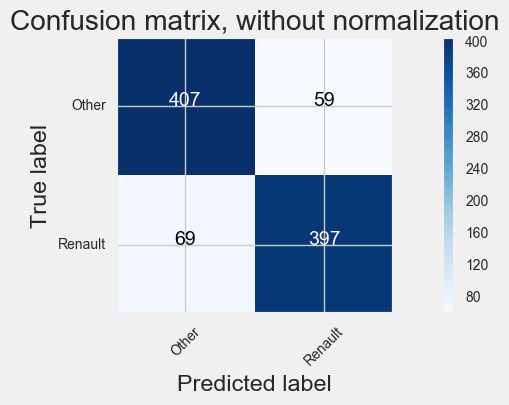

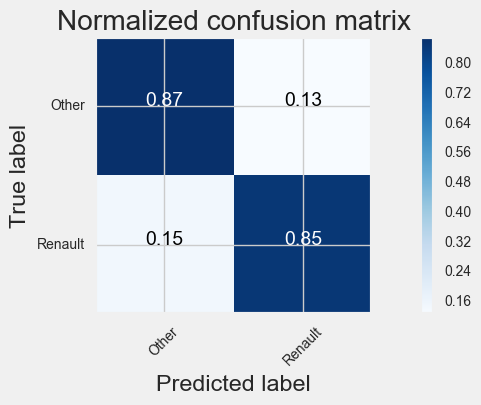

In [50]:
class_names = ['Other', 'Renault']

# Compute confusion matrix
cnf_matrix = confusion_matrix(target, y_val_hat > best_thresh)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Predictions Probability Distribution <a id='prob_distrib'></a>

(-0.01, 1.01)

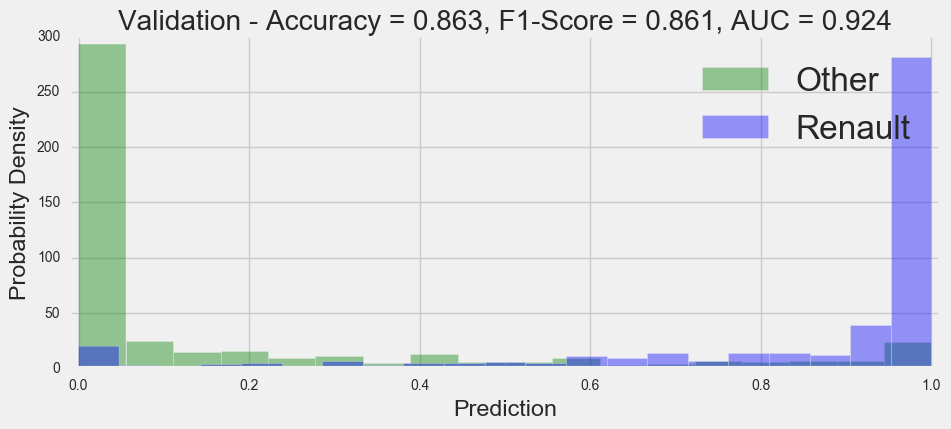

In [51]:
# Show prediction probability distribution
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,4)

plt.figure(); 
sns.distplot(y_val_hat[target==0], kde=False, color="g")
sns.distplot(y_val_hat[target==1], kde=False, color="b")

plt.legend(['Other','Renault'],fontsize=24)
plt.title('Validation - Accuracy = %.3f, F1-Score = %.3f, AUC = %.3f' %(accuracy, f1score, auc))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)

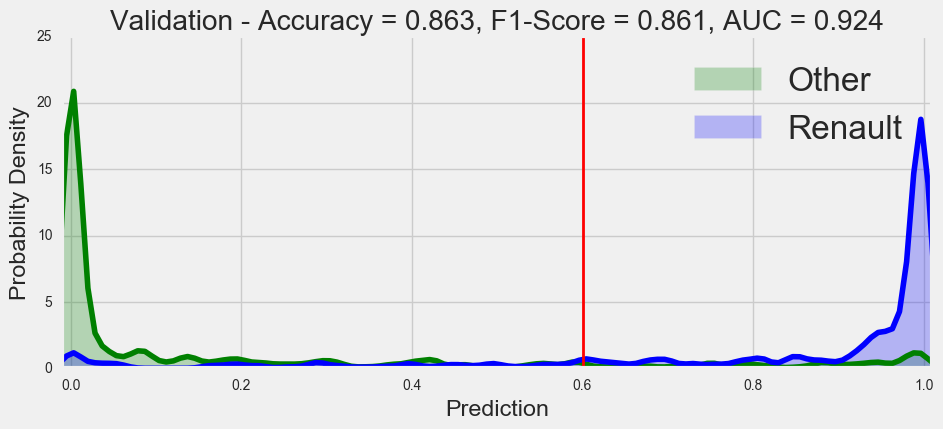

In [52]:
# Show prediction density plot
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,4)

plt.figure();
sns.kdeplot(y_val_hat[target==0], shade=True, color="g", bw=0.01)
sns.kdeplot(y_val_hat[target==1], shade=True, color="b", bw=0.01)
plt.legend(['Other','Renault'],fontsize=24)
plt.title('Validation - Accuracy = %.3f, F1-Score = %.3f, AUC = %.3f' %(accuracy, f1score, auc))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.axvline(x=best_thresh, linewidth=2, color='red')

# Cross-validation Images and Scoring <a id='crossv_images'></a>

In [53]:
# Create a dataframe with image addresses and their predictions
predictions = cval.copy()
predictions['pred'] = y_val_hat
print('Evaluated %d images' %len(predictions))
predictions.head()

Evaluated 932 images


image  label      pred
0  ../data/modeling/renault/renault_megane_trophy...      1  0.986459
1       ../data/modeling/renault/renault_wind_26.jpg      1  0.982352
2    ../data/modeling/other/mercedes_classe_c_87.jpg      0  0.875375
3                   ../data/modeling/other/06534.jpg      0  0.007333
4  ../data/modeling/renault/renault_captur_bleu_5...      1  0.999992

In [62]:
# Set the number of class 1 images to observe into a 50-50 balanced dataset
# Let's suppose class 1 as "Renault" and class 2 refering to "Other"
nclass2 =5
random.seed(101)

class1_pred_img = list(predictions[predictions['label']==0]['image'])
class2_pred_img = list(predictions[predictions['label']==1]['image'])

class1_pred_img = [class1_pred_img[i] for i in random.sample(range(len(class1_pred_img)), nclass2)]
class2_pred_img = [class2_pred_img[i] for i in random.sample(range(len(class2_pred_img)), nclass2)]
pred_sample = predictions[predictions['image'].isin(class1_pred_img+class2_pred_img)]
pred_smaple = pred_sample.reset_index().drop(['index'], axis=1)
print('Observing', len(pred_sample), 'cross-validation examples')

Observing 10 cross-validation examples


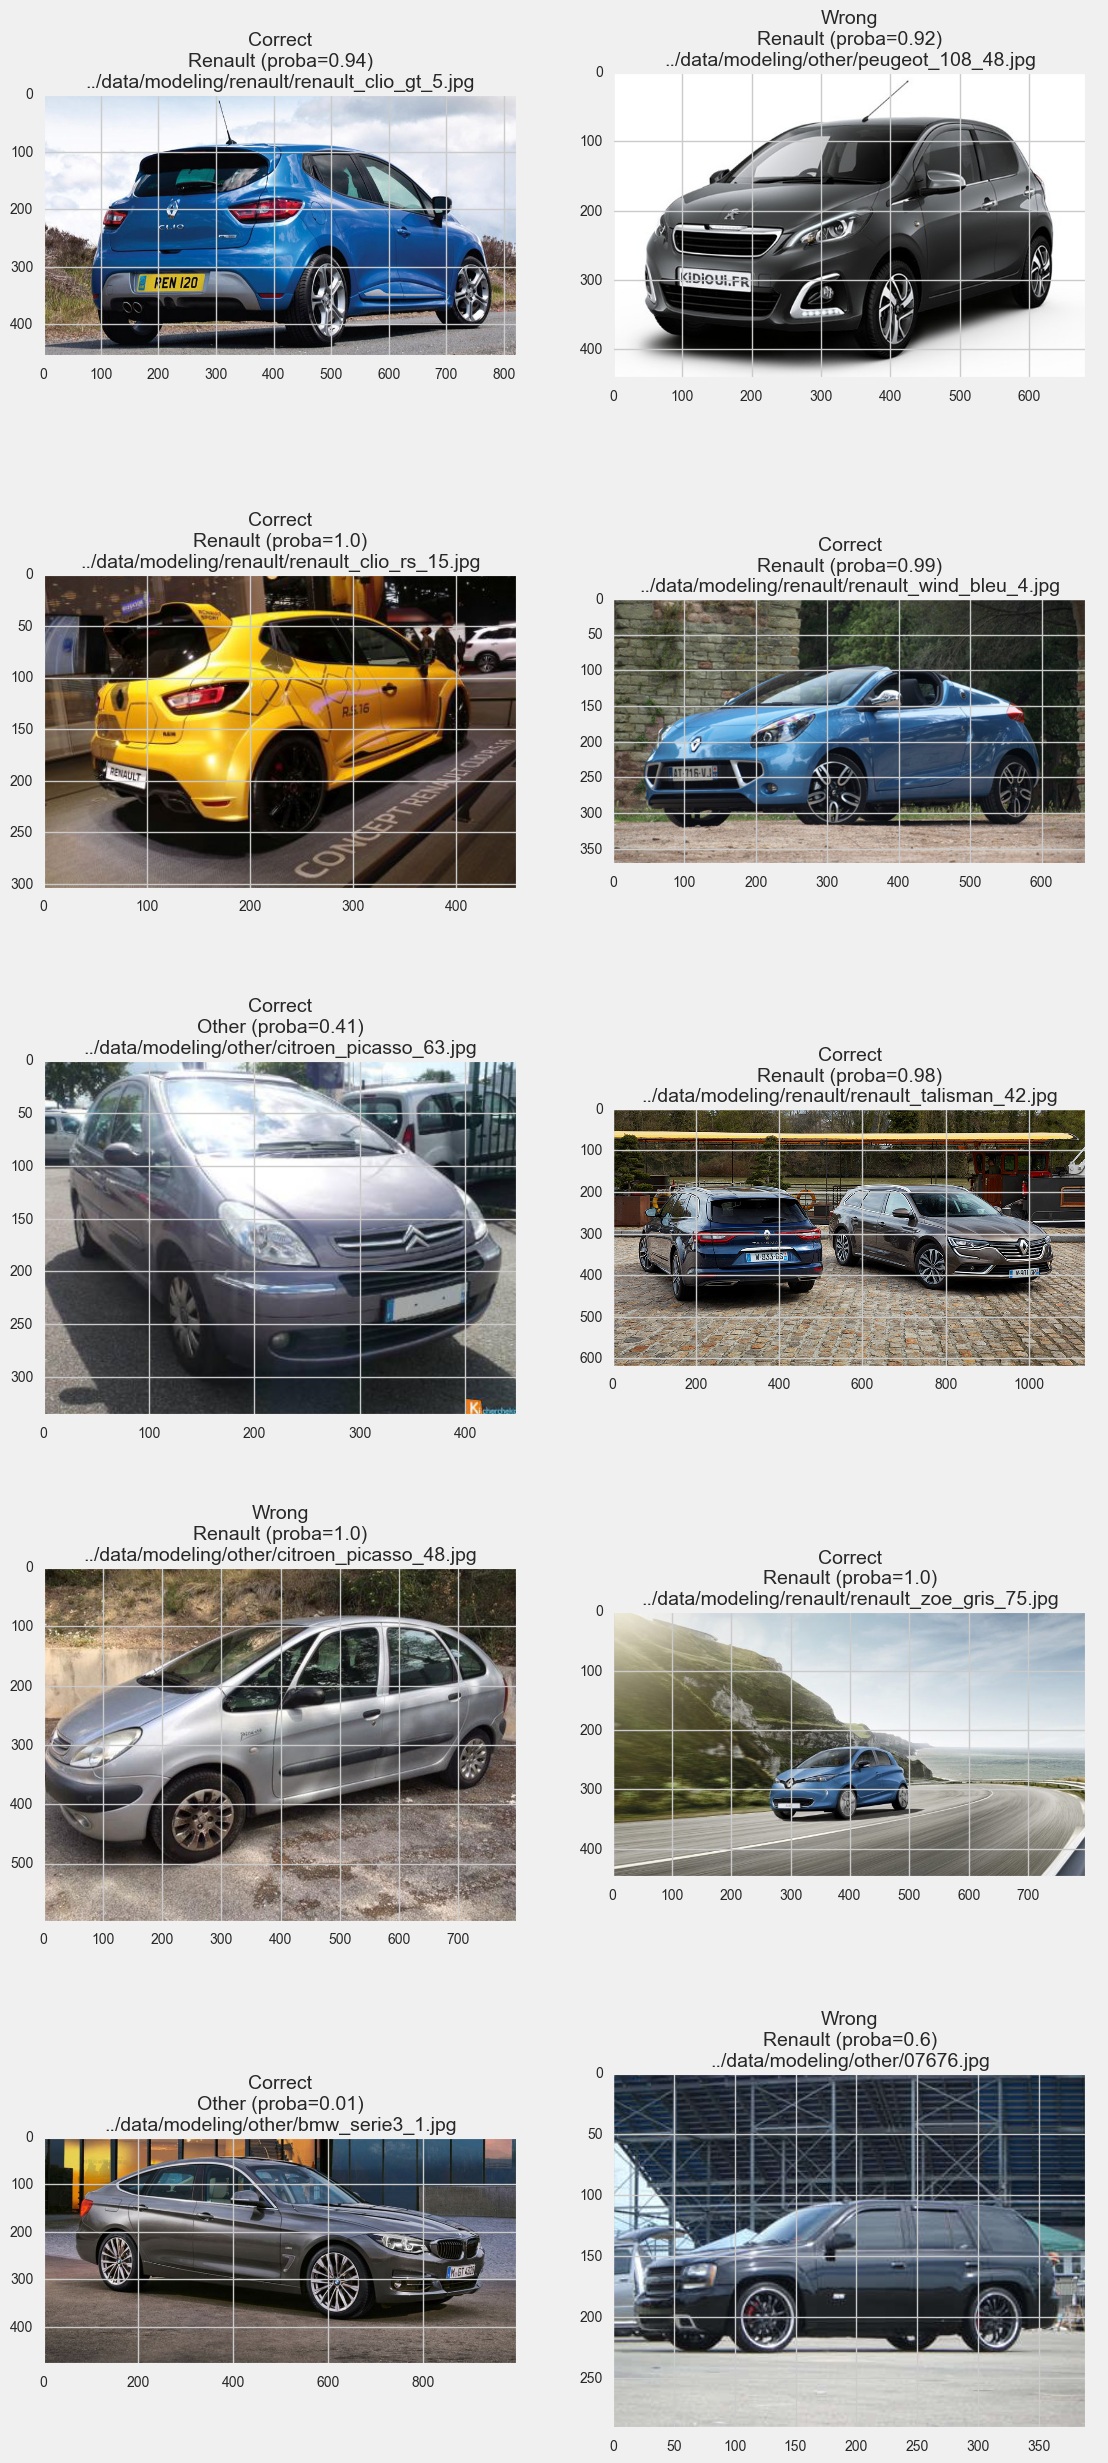

In [63]:
plot_img_score(pred_sample, best_thresh, labels=['Other', 'Renault'])

# False Positive Examples <a id='false_positives'></a>

Found 59 false positive exmaples.
Showing 2 observation(s):


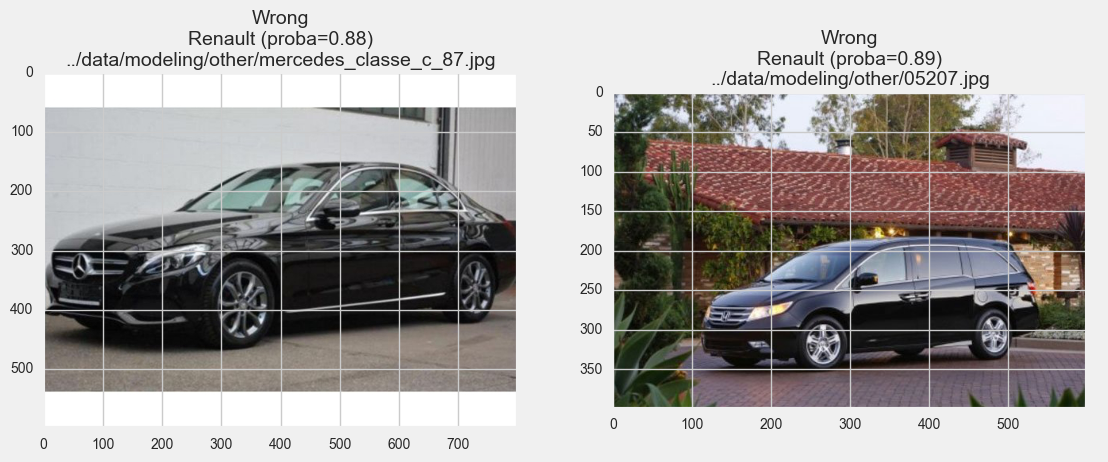

In [56]:
fp1 = predictions[(predictions['label'] == 0) & (predictions['pred'] > best_thresh)]
print('Found %.f false positive exmaples.' %len(fp1))
n_show = 2 if len(fp1)>2 else len(fp1)
print('Showing '+str(n_show)+' observation(s):')
plot_img_score(fp1.head(n_show), best_thresh, labels=['Other', 'Renault'])

In [57]:
pd.set_option('display.max_colwidth', -1)
fp1.head()

image  label      pred
2   ../data/modeling/other/mercedes_classe_c_87.jpg  0      0.875375
5   ../data/modeling/other/05207.jpg                 0      0.888010
60  ../data/modeling/other/05790.jpg                 0      0.772132
68  ../data/modeling/other/vw_passat_15.jpg          0      0.750130
88  ../data/modeling/other/05218.jpg                 0      0.748949

# False Negative Examples <a id='false_negatives'></a>

Found 69 false negative exmaples.
Showing 2 observation(s):


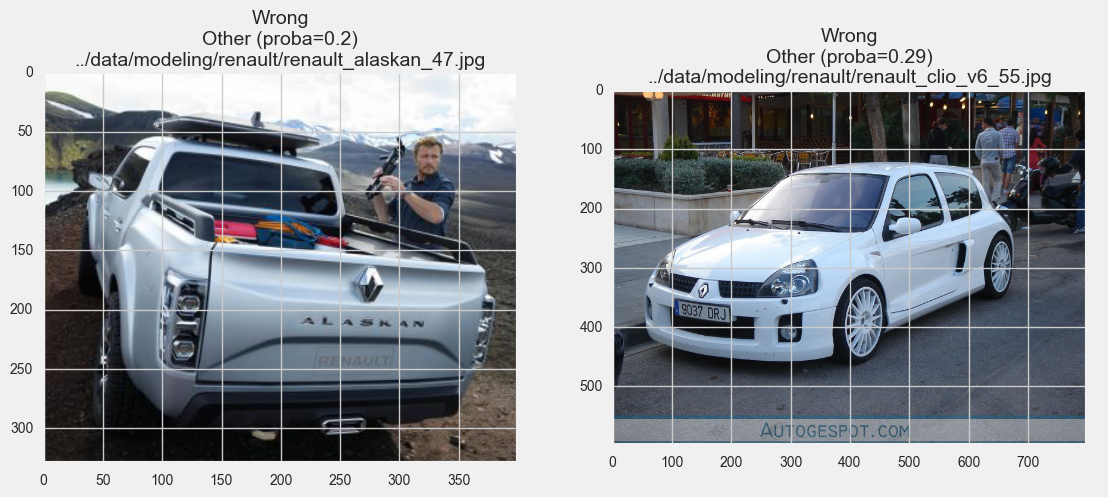

In [58]:
fn1 = predictions[(predictions['label'] == 1) & (predictions['pred'] < best_thresh)]
print('Found %.f false negative exmaples.' %len(fn1))
n_show = 2 if len(fn1)>2 else len(fn1)
print('Showing '+str(n_show)+' observation(s):')
plot_img_score(fn1.head(n_show), best_thresh, labels=['Other', 'Renault'])

In [59]:
fn1.head()

image  label          pred
7   ../data/modeling/renault/renault_alaskan_47.jpg      1      1.950115e-01
57  ../data/modeling/renault/renault_clio_v6_55.jpg      1      2.876412e-01
58  ../data/modeling/renault/renault_clio_v6_91.jpg      1      5.884165e-01
76  ../data/modeling/renault/renault_kadjar_gris_45.jpg  1      3.128040e-01
83  ../data/modeling/renault/renault_r5_86.jpg           1      4.678904e-07